In [82]:
import mne
import matplotlib
import os
import numpy as np
import pathlib
from scipy.signal import freqz
from mne.time_frequency.tfr import morlet
from mne.viz import plot_filter, plot_ideal_filter

from mne.preprocessing import create_eog_epochs

In [83]:
matplotlib.use('Qt5Agg')

In [84]:
set_data_folder=pathlib.Path('sub-032301-Not Addicted-preprocessed')
set_data_processed=os.path.join(set_data_folder,'sub-010002_EO.set')
data = mne.io.read_raw_eeglab(set_data_processed)
data.load_data()

Reading C:\Users\josep\sub-032301-Not Addicted-preprocessed\sub-010002_EO.fdt
Reading 0 ... 117860  =      0.000 ...   471.440 secs...


C:\Users\josep\AppData\Local\Temp/ipykernel_22216/3755362372.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(set_data_processed)
C:\Users\josep\AppData\Local\Temp/ipykernel_22216/3755362372.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(set_data_processed)


<RawEEGLAB | sub-010002_EO.fdt, 59 x 117861 (471.4 s), ~53.1 MB, data loaded>

In [85]:
data.pick(['eeg', 'eog']).load_data()
data.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, C3, Cz, C4, ...
 chs: 59 EEG
 custom_ref_applied: False
 dig: 59 items (59 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 250.0 Hz
>

In [86]:
channel_renaming_dict = {name: name.replace(' 0', '').lower()
                         for name in data.ch_names}
_ = data.rename_channels(channel_renaming_dict)  # happens in-place

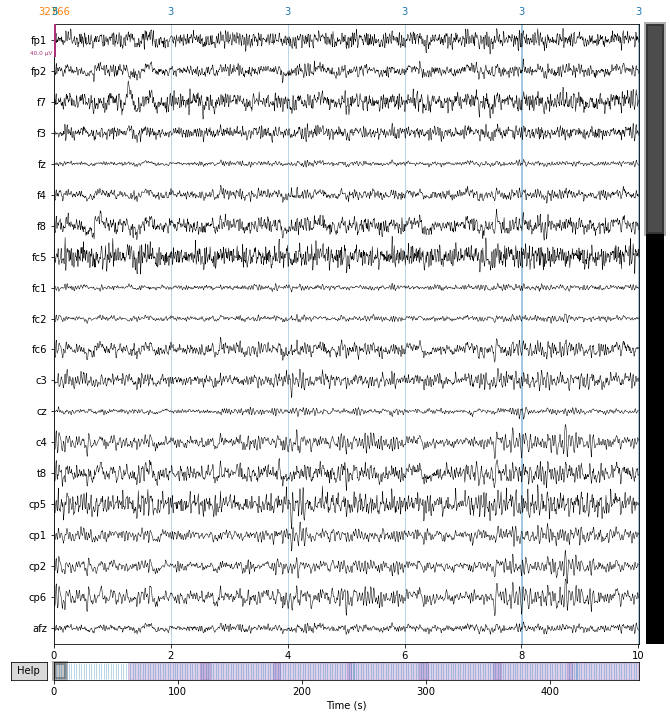

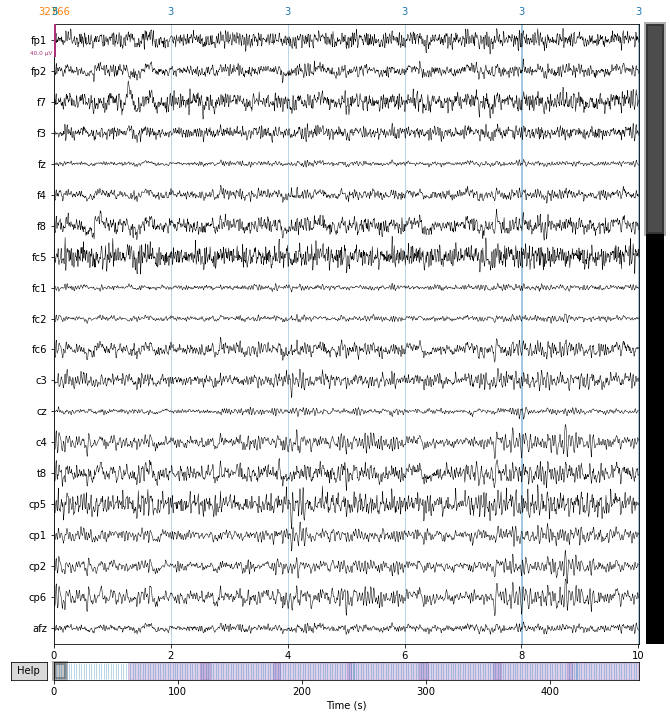

Channels marked as bad: none


In [87]:
data.plot()

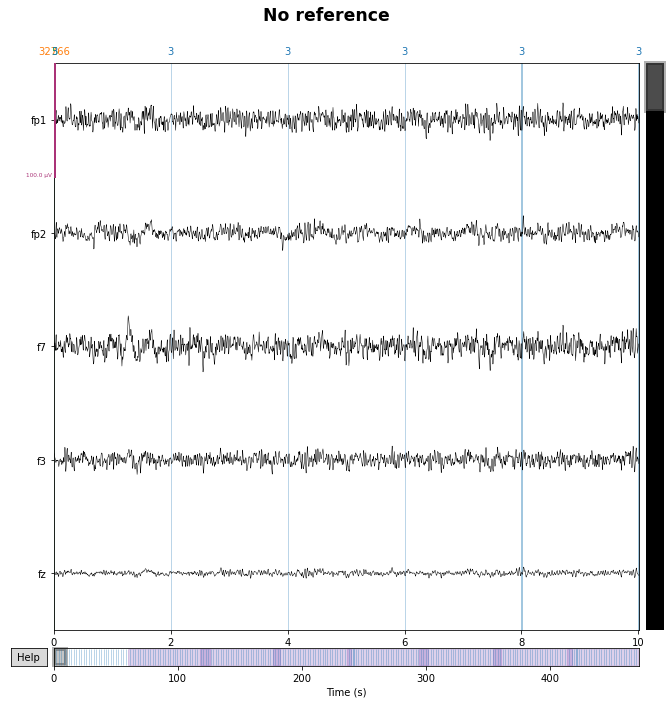

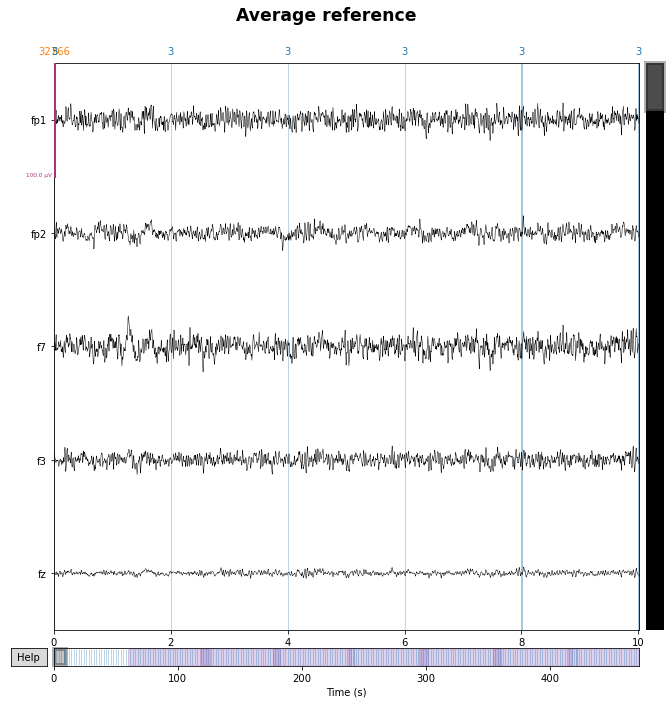

Channels marked as bad: none
Channels marked as bad: none


In [88]:
for proj in (False, True):
    fig = data.plot(n_channels=5, proj=proj, scalings=dict(eeg=50e-6))
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = 'Average' if proj else 'No'
    fig.suptitle(f'{ref} reference', size='xx-large', weight='bold')

In [89]:
print(data.ch_names)

['fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 'fc5', 'fc1', 'fc2', 'fc6', 'c3', 'cz', 'c4', 't8', 'cp5', 'cp1', 'cp2', 'cp6', 'afz', 'p7', 'p3', 'pz', 'p4', 'p8', 'po9', 'o1', 'oz', 'o2', 'po10', 'af7', 'af3', 'af4', 'af8', 'f5', 'f1', 'f2', 'f6', 'ft7', 'fc3', 'fc4', 'ft8', 'c5', 'c1', 'c2', 'c6', 'cp3', 'cpz', 'cp4', 'tp8', 'p5', 'p1', 'p2', 'p6', 'po7', 'po3', 'poz', 'po4', 'po8']


In [90]:
print(len(data.annotations))
print(set(data.annotations.duration))
print(set(data.annotations.description))
print(data.annotations.onset[0])

242
{64.856, 65.604, 66.028, 66.052, 64.072, 0.004, 57.758, 63.384}
{'3', 'boundary', '5', '32766'}
0.0


In [91]:
events_from_annot, event_dict = mne.events_from_annotations(data)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['3', '32766', '5', 'boundary']
{'3': 1, '32766': 2, '5': 3, 'boundary': 4}
[[   0    0    2]
 [   0    0    3]
 [   0    0    1]
 [ 500    0    1]
 [1000    0    1]]


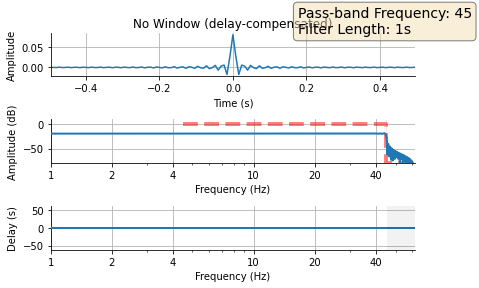

In [92]:
from mne.viz import plot_filter, plot_ideal_filter
import matplotlib.pyplot as plt

sfreq = 125
f_p = 45
nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

n = int(round(1 * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq  # center our sinc
h = np.sinc(2 * f_p * t) / (4 * np.pi)
flim = (1., sfreq / 2.)
fig = plot_filter(h, sfreq, freq, gain, 'No Window', flim=flim, compensate=True)

textstr = '\n'.join((
    'Pass-band Frequency: '+str(f_p),
    'Filter Length: 1s'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
fig.text(0.7, 0.9, textstr, fontsize=14, bbox=props)

plt.show()
fig.savefig('ringing_45hz.png')

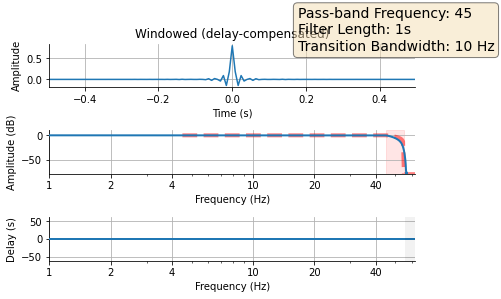

In [94]:


from scipy import signal

import numpy as np
from math import pi
trans_bandwidth = 10  # 10 Hz transition band
f_s = f_p + trans_bandwidth

freq = [0., f_p, f_s, nyq]
gain = [1., 1., 0., 0.]
h = signal.firwin2(n, freq, gain, nyq=nyq)
fig = plot_filter(h, sfreq, freq, gain, 'Windowed',
                  flim=flim, compensate=True)

textstr = '\n'.join((
    'Pass-band Frequency: '+str(f_p),
    'Filter Length: 1s',
    'Transition Bandwidth: '+str(trans_bandwidth)+' Hz'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
fig.text(0.7, 0.88, textstr, fontsize=14, bbox=props)

plt.show()
fig.savefig('no_ringing_45hz.png')



In [95]:
print(data.info)

<Info | 8 non-empty values
 bads: []
 ch_names: fp1, fp2, f7, f3, fz, f4, f8, fc5, fc1, fc2, fc6, c3, cz, c4, ...
 chs: 59 EEG
 custom_ref_applied: False
 dig: 59 items (59 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 250.0 Hz
>


In [96]:
data.info['bads']=['fp1']

In [97]:
data.info

<Info | 9 non-empty values
 bads: 1 items (fp1)
 ch_names: fp1, fp2, f7, f3, fz, f4, f8, fc5, fc1, fc2, fc6, c3, cz, c4, ...
 chs: 59 EEG
 custom_ref_applied: False
 dig: 59 items (59 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 250.0 Hz
>

In [98]:
data1=data.drop_channels(['fp2'])


Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (13.204 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (13.204 sec)



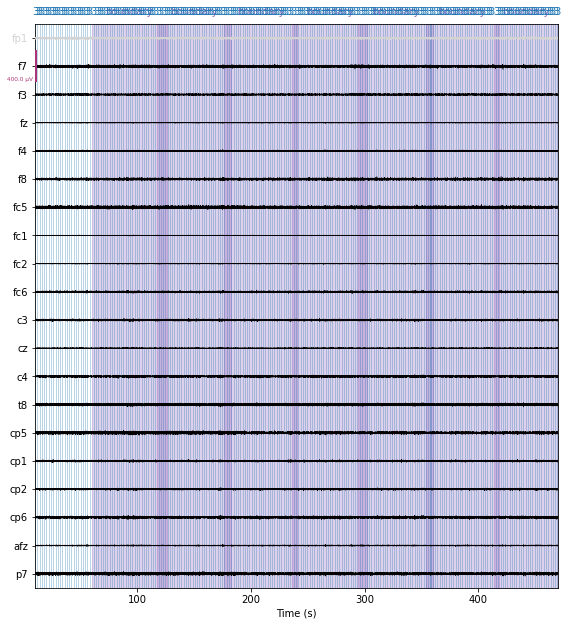

Channels marked as bad: ['fp1']


In [99]:
sfreq = data1.info['sfreq']
l_freq = 0.5
h_freq = 50
method = 'fir'
fir_design = 'firwin2'

filter_params = mne.filter.create_filter(data1.get_data(), sfreq,
                                         l_freq=l_freq, h_freq=h_freq, 
                                         fir_design=fir_design)


filt_data = data1.filter(l_freq, h_freq,
                           method=method, 
                           fir_design=fir_design)

plot = filt_data.plot(scalings = dict(eeg=20e-5),
                      start = 10,
                      duration = 460,
                      show =True,
                      show_scrollbars=False)

In [100]:
t_idx = data.time_as_index([10., 460.])  

data, baseline_df = data['c3', t_idx[0]:t_idx[1]]

In [105]:
from scipy.signal import welch
import pandas as pd
sample_rate = 250# in hz

# specify the lowest frequency your interested in
low = 5

# this is the window size and ensures there are at least 2 cycles 
# of the lowest frequency in the window
nperseg = (2 / low)*sample_rate

# Compute the periodogram (Welch)
freqs, psd = welch(baseline_df, 
                   sample_rate, 
                   nperseg=nperseg,
                   scaling='density', 
                   axis=0)

# put into a df
psd = pd.DataFrame(psd, index = freqs)

print('Welch Output')
psd.index.name = 'Hz'
psd.columns = ['Power']
display(psd)

Welch Output


,Power
Hz,
0.0,1.066667e-06
2.5,1.216388e-03
5.0,6.004209e-05
7.5,3.752601e-06
10.0,6.004030e-07
12.5,1.500937e-07
15.0,4.900591e-08
17.5,1.914016e-08
20.0,8.504833e-09


In [113]:
%%time
from scipy.signal import welch
import numpy as np

def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band

    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd

baseline_power = bandpower(baseline_df, sample_rate, [8,12], output=False)



Wall time: 8.95 ms


In [120]:


def power_measures(data, output=False):
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    welch_df = welch_df.T
    
    if output:
        display(welch_df)
    
    return welch_df

print('Baseline Mean Power')
baseline_power = power_measures(baseline_df, output=True)




Baseline Mean Power


power_delta    0.000009
power_theta    0.000042
power_alpha    0.000008
power_beta     0.000001
power_gamma    0.000001
dtype: float64